In [1]:
import sys;sys.path.append('..')
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from utils.plot import plot_heatmap
from utils.dataloader import synthesize_data, generate_logged_data
from src.pointwise import PointwiseRecommender
from conf.settings.default import DataConfig, PointwiseConfig
from utils.metrics import calc_dcg
%matplotlib inline

In [22]:
params = DataConfig(
    n_users=100, 
    n_items=500, 
    mu_u=1,
    mu_i=100, 
    dirichlet_noise=(0.3, 0.01), 
    n_factors=10, 
    k=15, 
    n_rankings_per_user=5,
    p_power=100.0,
)
Vui = synthesize_data(params)
dataset = generate_logged_data(params, Vui)

In [23]:
dataset.train[:,:,5].mean()

0.010222222222222223

In [24]:
dataset.test[:,:,2].mean()

0.362

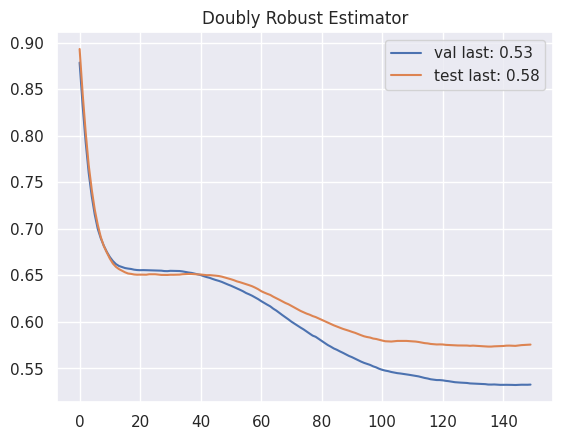

In [40]:
# DR

expo_labels = dataset.train[:,:,4]
pscores = dataset.train[:,:,3]

np.random.seed(1)
mu_hat = np.clip(dataset.train[:,:,2] + np.random.uniform(-0.01, 0.01), 0, 1)
clicks = dataset.train[:,:,5]

X_ui = (expo_labels/pscores)*(clicks-mu_hat)+mu_hat

train = np.concatenate([dataset.train[:,:,[0,1]], X_ui[:,:,None]], axis=2)

expo_labels = dataset.val[:,:,4]
pscores = dataset.val[:,:,3]

np.random.seed(1)
mu_hat = np.clip(dataset.val[:,:,2] + np.random.uniform(-0.01, 0.01), 0, 1)
clicks = dataset.val[:,:,5]

X_ui = (expo_labels/pscores)*(clicks-mu_hat)+mu_hat

val = np.concatenate([dataset.val[:,:,[0,1]], X_ui[:,:,None]], axis=2)
val = val.reshape(-1,3)

test = dataset.test.reshape(-1,3)

model = PointwiseRecommender(
        n_users=params.n_users,
        n_items=params.n_items,
        n_factors=2,
        lr=0.02,
        n_epochs=150,
        reg=0.01,
        seed=params.seed,
        batch_size=150,
        n_positions=params.k,
)

val_loss, test_dr_loss, val_dr_dcg, test_dr_dcg = model.fit((train, val, test))

plt.title('Doubly Robust Estimator')
plt.plot(val_loss, label=f"val last: {val_loss[-1]:.2f}")
plt.plot(test_dr_loss, label=f"test last: {test_dr_loss[-1]:.2f}")
plt.legend()
plt.show()

In [41]:
scores = model.predict(user_ids=test[:,0], item_ids=test[:,1])
print(f'mean: {scores.mean():.3f}, min: {scores.min():.3f}, max: {scores.max():.3f}, std: {scores.std():.3f}')

mean: 0.372, min: 0.000, max: 1.000, std: 0.266


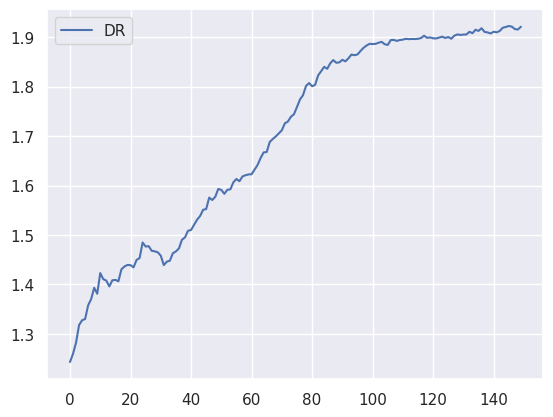

In [42]:
plt.plot(test_dr_dcg, label="DR")
plt.legend()
plt.show()

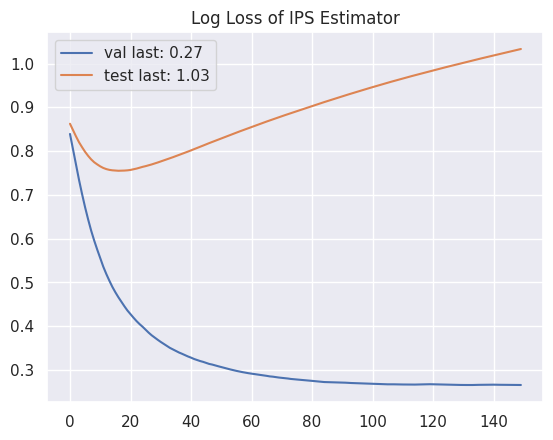

In [50]:
# IPS
pscores = dataset.train[:,:,3]
clicks = dataset.train[:,:,5]

X_ui = clicks/pscores
train = np.concatenate([dataset.train[:,:,[0,1]], X_ui[:,:,None]], axis=2)

pscores = dataset.val[:,:,3]
clicks = dataset.val[:,:,5]

X_ui = clicks/pscores
val = np.concatenate([dataset.val[:,:,[0,1]], X_ui[:,:,None]], axis=2)
val = val.reshape(-1,3)

test = dataset.test.reshape(-1,3)

model = PointwiseRecommender(
        n_users=params.n_users,
        n_items=params.n_items,
        n_factors=2,
        lr=0.007,
        n_epochs=150,
        reg=0.01,
        seed=params.seed,
        batch_size=150,
        n_positions=params.k,
)

val_loss, test_ips_loss, val_ips_dcg, test_ips_dcg = model.fit((train, val, test))

plt.title('Log Loss of IPS Estimator')
plt.plot(val_loss, label=f"val last: {val_loss[-1]:.2f}")
plt.plot(test_ips_loss, label=f"test last: {test_ips_loss[-1]:.2f}")
plt.legend()
plt.show()

In [51]:
scores = model.predict(user_ids=test[:,0], item_ids=test[:,1])
print(f'mean: {scores.mean():.3f}, min: {scores.min():.3f}, max: {scores.max():.3f}, std: {scores.std():.3f}')

mean: 0.099, min: 0.002, max: 1.000, std: 0.130


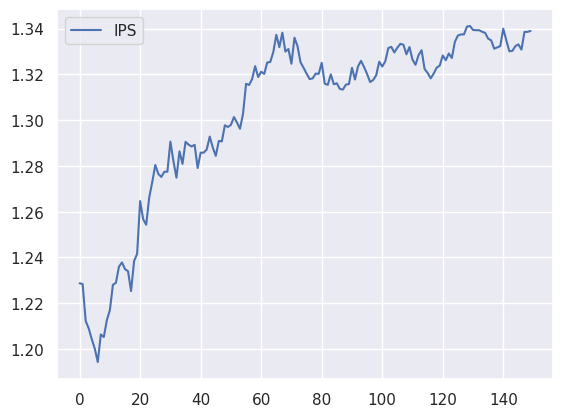

In [52]:
plt.plot(test_ips_dcg, label="IPS")
plt.legend()
plt.show()

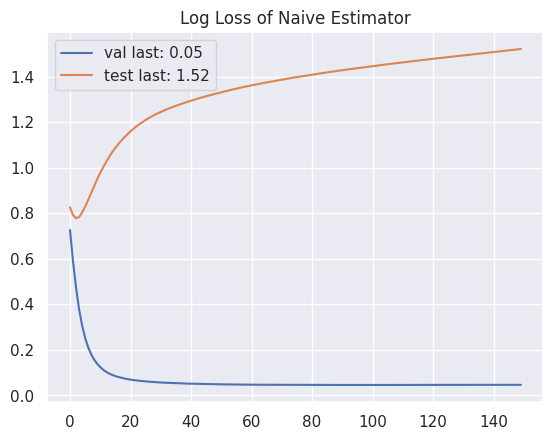

In [60]:
# Naive
train = dataset.train[:,:,[0,1,5]]
val = dataset.val[:,:,[0,1,5]].reshape(-1,3)
test = dataset.test.reshape(-1,3)


model = PointwiseRecommender(
        n_users=params.n_users,
        n_items=params.n_items,
        n_factors=2,
        lr=0.03,
        n_epochs=150,
        reg=0.01,
        seed=params.seed,
        batch_size=150,
        n_positions=params.k,
)

val_loss, test_naive_loss, val_naive_dcg, test_naive_dcg = model.fit((train, val, test))

plt.title('Log Loss of Naive Estimator')
plt.plot(val_loss, label=f"val last: {val_loss[-1]:.2f}")
plt.plot(test_naive_loss, label=f"test last: {test_naive_loss[-1]:.2f}")
plt.legend()
plt.show()

In [61]:
scores = model.predict(user_ids=test[:,0], item_ids=test[:,1])
print(f'mean: {scores.mean():.3f}, min: {scores.min():.3f}, max: {scores.max():.3f}, std: {scores.std():.3f}')

mean: 0.027, min: 0.000, max: 0.999, std: 0.076


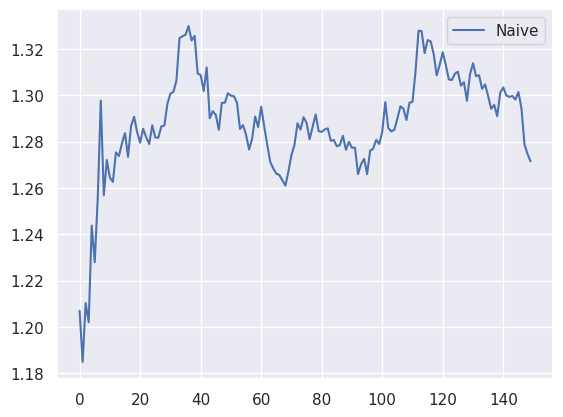

In [62]:
plt.plot(test_naive_dcg, label="Naive")


plt.legend()
plt.show()

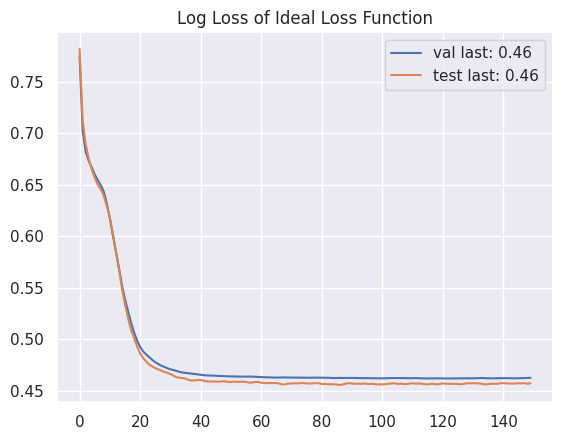

In [63]:
# ideal
train = dataset.train[:,:,[0,1,2]]
val = dataset.val[:,:,[0,1,2]].reshape(-1,3)
test = dataset.test.reshape(-1,3)

model = PointwiseRecommender(
        n_users=params.n_users,
        n_items=params.n_items,
        n_factors=2,
        lr=1e-1,
        n_epochs=150,
        reg=0.01,
        seed=params.seed,
        batch_size=150,
        n_positions=params.k,
)

val_loss, test_ideal_loss, val_ideal_dcg, test_ideal_dcg = model.fit((train, val, test))

plt.title('Log Loss of Ideal Loss Function')
plt.plot(val_loss, label=f"val last: {val_loss[-1]:.2f}")
plt.plot(test_ideal_loss, label=f"test last: {test_ideal_loss[-1]:.2f}")
plt.legend()
plt.show()

In [64]:
scores = model.predict(user_ids=test[:,0], item_ids=test[:,1])
print(f'mean: {scores.mean():.3f}, min: {scores.min():.3f}, max: {scores.max():.3f}, std: {scores.std():.3f}')

mean: 0.370, min: 0.005, max: 0.977, std: 0.271


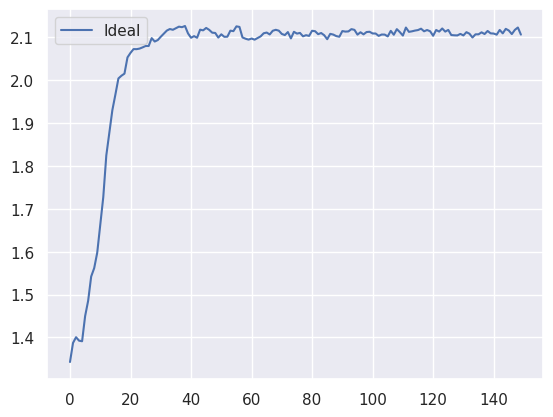

In [65]:
plt.plot(test_ideal_dcg, label="Ideal")
plt.legend()

plt.show()

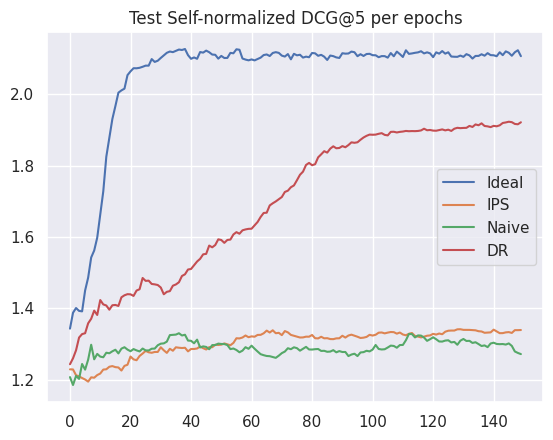

In [66]:
plt.title('Test Self-normalized DCG@5 per epochs')
plt.plot(test_ideal_dcg, label="Ideal")
plt.plot(test_ips_dcg, label="IPS")
plt.plot(test_naive_dcg, label="Naive")
plt.plot(test_dr_dcg, label="DR")

plt.legend()
plt.show()

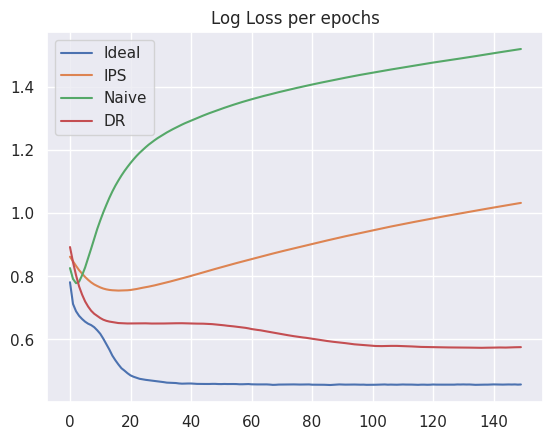

In [68]:
plt.title('Log Loss per epochs')
plt.plot(test_ideal_loss, label="Ideal")
plt.plot(test_ips_loss, label="IPS")
plt.plot(test_naive_loss, label="Naive")
plt.plot(test_dr_loss, label="DR")

plt.legend()
plt.show()